In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
import torch
torch.cuda.empty_cache()

In [4]:
import onnx
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
from PIL import Image
from torch import optim
from tqdm import tqdm
import netron
import time
from IPython.display import IFrame


# # Define paths
train_dir = "rgb_data_old/train"
test_dir = "rgb_data_old/test"

# train_dir = "rgb_data_new/train"
# test_dir = "rgb_data_new/test"


# Define transforms
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# train_dir = "grayscale_data/train"
# test_dir = "grayscale_data/test"

# # Grayscale
# transform = transforms.Compose([
#     transforms.Resize((227, 227)),
#     transforms.Grayscale(num_output_channels=1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485], std=[0.229])
# ])


class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)

    def __len__(self):
        total_images = sum(len(files) for _, _, files in os.walk(self.data_dir))
        return total_images

    def __getitem__(self, idx):
        class_idx = idx // (len(os.listdir(os.path.join(self.data_dir, self.classes[0]))))
        class_dir = os.path.join(self.data_dir, self.classes[class_idx])
        files = os.listdir(class_dir)
        file_idx = idx % len(files)
        img_name = os.path.join(class_dir, files[file_idx])
        image = Image.open(img_name)
        label = class_idx
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets and dataloaders
train_dataset = CustomDataset(train_dir, transform=transform)
test_dataset = CustomDataset(test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,num_workers = 4)

def show_netron(model_path, port):
    time.sleep(3.)
    netron.start(model_path, address=("localhost", port), browse=False)
    return IFrame(src=f"http://localhost:{port}/", width="100%", height=400)


In [5]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# torch.manual_seed(0)
# np.random.seed(0)


# Define model
model = resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes))
model.to(device)


# loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available is not None:
    criterion = criterion.cuda()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

In [6]:
num_epochs = 4

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    correct_train = 0
    total_train = 0


    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} Training', leave=True)
    for images, labels in train_progress_bar:
        images, labels = images.to(device), labels.to(device)
        # forward pass
        optimizer.zero_grad()
        outputs = model(images)
        # backward pass + run optimizer to update weights
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # keep track of loss value
        train_running_loss += loss.item()

        pred = torch.argmax(outputs,dim=1)      #torch.max(outputs, 1)   
        total_train += labels.size(0)
        correct_train += (pred == labels).sum().item()

        train_progress_bar.set_postfix(loss=f'{train_running_loss/(len(train_progress_bar)):.4f}')

    train_loss_avg = train_running_loss / len(train_loader)
    train_losses.append(train_loss_avg)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss_avg:.4f}')

    # Testing phase
    model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0

    test_progress_bar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} Validation', leave=True)

    with torch.no_grad():
        for images, labels in test_progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()

            predicted = torch.argmax(outputs,dim=1)

            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            test_progress_bar.set_postfix(val_loss=f'{test_running_loss/(len(test_progress_bar)):.4f}')
    test_loss_avg = test_running_loss / len(test_loader)
    test_losses.append(test_loss_avg)
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)
    lr_scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {test_loss_avg:.4f},Validation Accuracy: {test_accuracy:.4f}')

print("Training Finished!")


Epoch 1/4 Training: 100%|█| 8/8 [00:04<00:00,  1.73it/s, loss=0


Epoch [1/4], Training Loss: 0.6011


Epoch 1/4 Validation: 100%|█| 5/5 [00:02<00:00,  1.73it/s, val_


Epoch [1/4], Validation Loss: 0.4896,Validation Accuracy: 0.7532


Epoch 2/4 Training: 100%|█| 8/8 [00:04<00:00,  1.89it/s, loss=0


Epoch [2/4], Training Loss: 0.3748


Epoch 2/4 Validation: 100%|█| 5/5 [00:02<00:00,  1.80it/s, val_


Epoch [2/4], Validation Loss: 0.3890,Validation Accuracy: 0.8237


Epoch 3/4 Training: 100%|█| 8/8 [00:04<00:00,  1.83it/s, loss=0


Epoch [3/4], Training Loss: 0.3092


Epoch 3/4 Validation: 100%|█| 5/5 [00:02<00:00,  1.77it/s, val_


Epoch [3/4], Validation Loss: 0.3191,Validation Accuracy: 0.8590


Epoch 4/4 Training: 100%|█| 8/8 [00:04<00:00,  1.80it/s, loss=0


Epoch [4/4], Training Loss: 0.2857


Epoch 4/4 Validation: 100%|█| 5/5 [00:02<00:00,  1.68it/s, val_

Epoch [4/4], Validation Loss: 0.2936,Validation Accuracy: 0.8750
Training Finished!


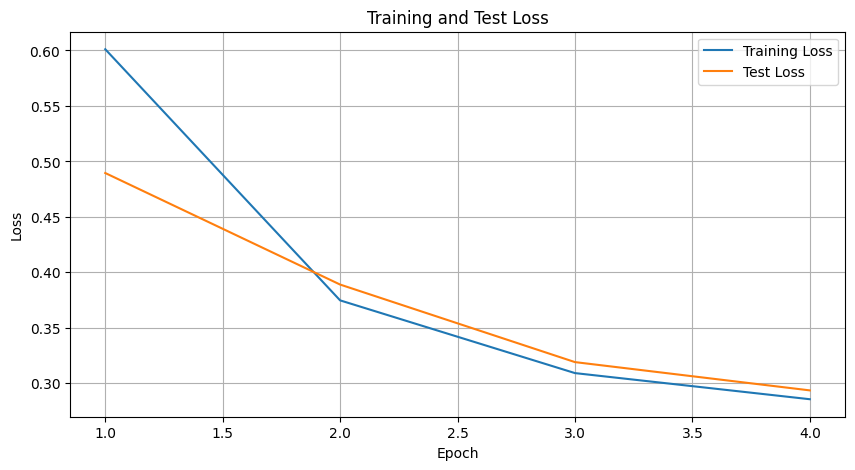

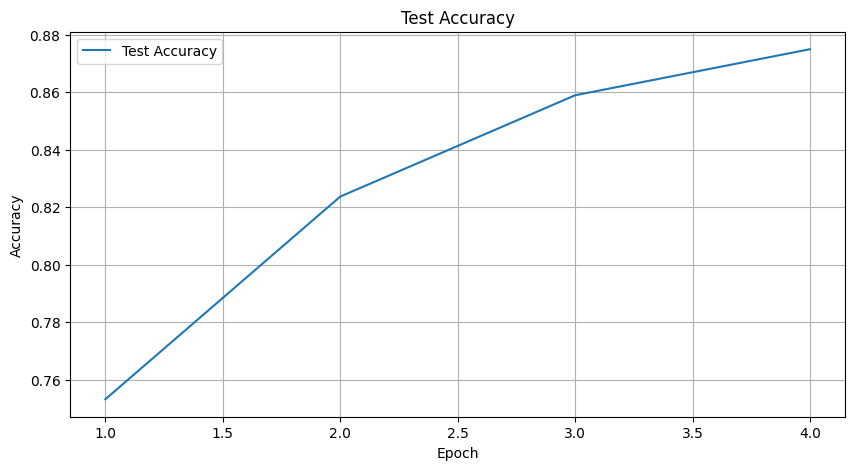

In [8]:
import matplotlib.pyplot as plt

# Plotting training and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Validation Accuracy Score: 0.8725761772853186
F1 Score: 0.8730149155544833


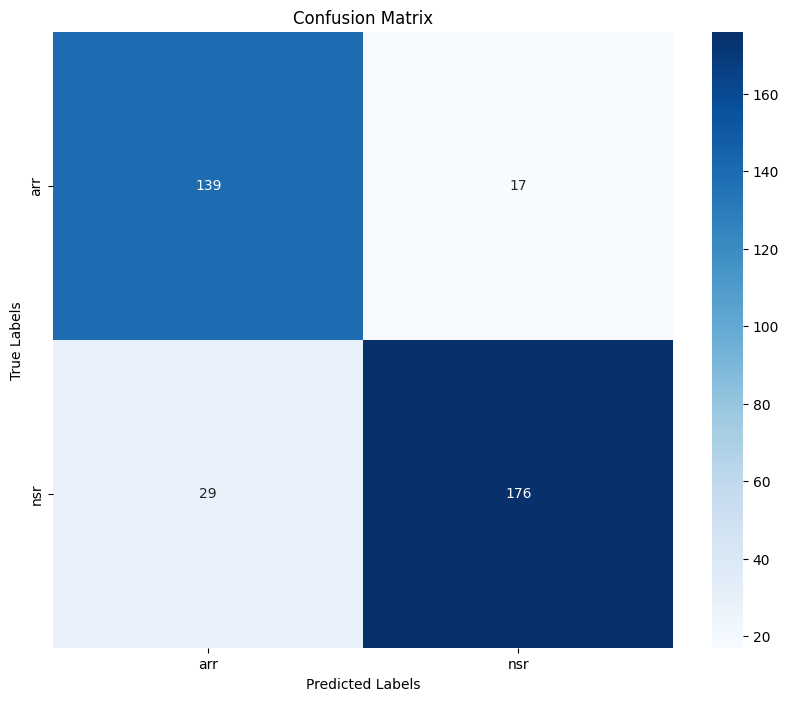

In [9]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets

# Define a function for validation
def validate(model, validation_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred



validation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# # Grayscale
# validation_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.Grayscale(num_output_channels=1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485], std=[0.229])
# ])

validation_dir = "rgb_data_old_validation"
validation_dataset = datasets.ImageFolder(root=validation_dir, transform=validation_transform)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
  


# Perform validation
y_true, y_pred = validate(model, validation_dataloader)

# Calculate accuracy score and f1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

# Print accuracy score and f1 score
print(f'Validation Accuracy Score: {accuracy}')
print(f'F1 Score: {f1}')


class_names = validation_dataset.classes


# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# model_path = './resnet18_newdataset_reguiresgradfalse_model.pth'
model_path = './resnet18_newdataset_reguiresgradtrue_model.pth'
# model_path = './resnet18_ogscalogramdataset_model.pth'
torch.save(model.state_dict(), model_path)